# Introduction

In this notebook we will be working through task 1 of the qc mentorship program. In this case the quantum simulator of my choise will be qiskit, the reason for this is my previous experience in coding with the program, as well as having a very simple sintax in Python.  
To run this code and instalation of qiskit is required and it can be found in https://qiskit.org/documentation/install.html 

In [68]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector, state_fidelity
from qiskit.visualization import plot_state_qsphere
import random, math
import numpy as np
from scipy import optimize as opt
import matplotlib.pyplot as plt 
from timeit import default_timer as timer
import seaborn as sbn
from IPython.display import Image
import pandas as pd

# Important functions

## Building the circuit
The first step of this problem is to define the circuit functions that will allow us to generate a circuit of with L layers without manually constructing it every time. Qiskit has a useful class called QuantumCircuit, which allows us to insert the desired gates as prebuit methods as we will see bellow

In [2]:
#Defining the odd blocks 
def odd_block(qc,theta):
    for i in range(4):
        qc.rx(theta[i],i)  

        
        
#Defining the even blocks
def even_block(qc,theta):
    #rz gates
    for i in range(4):
        qc.rz(theta[i],i)
    #cz gates
    for i in range(4):
        for j in range(i+1,4):
            qc.cz(i,j)        


            
#Defining a layer
def circuit_layer(qc,theta1,theta2):
    odd_block(qc,theta1)
    even_block(qc,theta2)
    

### Example 


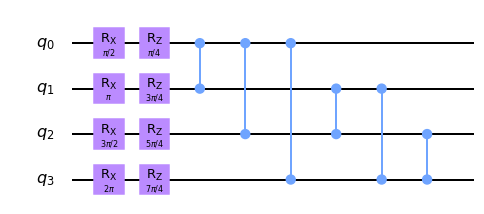

In [3]:
#Creation of a 4 qubit circuit
qc_example = QuantumCircuit(4)

#Input angles for our circuit 
theta_odd = [ math.pi/2, math.pi, 3*math.pi/2, 2*math.pi]
theta_even= [math.pi/4, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]

#Adding the layer
circuit_layer(qc_example,theta_odd,theta_even)

#Image of the resulting circuit 
qc_example.draw('mpl')

## Random State Vector

A general four qubit state can be written as $\ket{q_{0}q_{1}q_{2}q_{3}}$, with each qubit represented as present $\ket{1}$ or not $\ket{0}$, counting the two possible ways qubits can be found in general states we arrive at $2^{4} = 16$, which will be the dimension of our random state complex vector. 
Qiskit does not allow for a generic complex array to be treated as a statevector, but it can be easily transformed in a Statevector class that can be used in combination with the previously built circuit.

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$

In [4]:
#Defining random state vector 
def rand_state():
    #random 16 dimensional complex vector (4 qubits)
    vec = np.zeros((16,1), dtype=np.complex)
    for i in range(16):
        vec[i]=(complex(random.uniform(-1,1),random.uniform(-1,1)))
        
    #normalization
    vec = vec/np.linalg.norm(vec,ord=2)
    
    #transform to statevector
    vec = Statevector(vec)

    return vec

### Example
The qiskit library also has very useful visualization functions to make sense of higher dimeisional qubits states. In the next cell we display a random vector state in the qsphere. 

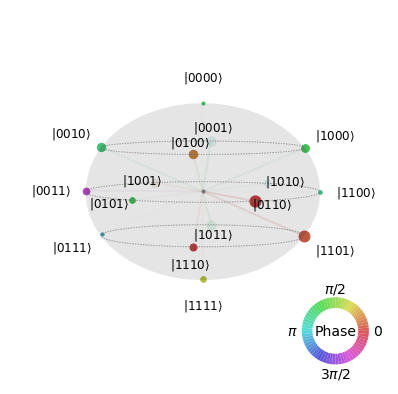

In [5]:
#Defining the random vector 
random_sv = rand_state()
plot_state_qsphere(random_sv.data)

# Constructing the problem 
To facilitate the optimization problem we would want a function that automatically takes the input of the number of layers (L), the parameters ($\theta$), and the random vector in order to have an explicit cost function to minimize.

The function in question is *running_circuit*, that has a scalar output that we wish to minimize with respect to theta. In this function we first build L layers of the previously defined circuit and use a useful method of the Statevector class, which allows us to evolve an initial state according to a circuit, without the need to run the circuit and reconstruct the state from the measurements. 

In [6]:
#Check norm of the difference of two states
def check_diff(random_sv,circuit_sv):
    diff = circuit_sv - random_sv
    epsilon = np.linalg.norm(diff.data,ord=2)**2
    return epsilon 


#Creating the circuit and result 
#Theta is a 4*2L array 1D array of numbeers 
def running_circuit(theta,L,random_sv):
    
    #initiating circuit and vector 
    mycircuit = QuantumCircuit(4)
    initial_sv = Statevector.from_label('0000')
    
    #creating the layers
    for i in range(L):
        circuit_layer(mycircuit,theta[4*i:4*i+4],theta[4*i+4:4*i+8])
        
    #evolving the statevector
    circuit_sv = initial_sv.evolve(mycircuit)
    
    #comparing to the original 
    epsilon = check_diff(random_sv,circuit_sv)
    
    return epsilon

# Solving the problem
With all the previous functions defined it is just a matter of calculating the minimun error for different layers in the circuit. Below is the code used to calculate the results, due to the long time it takes to run it, previously calculated images and results will be used

## Choice of minimization algorithm 
The minimize function form scipi uses a wide variety of different minimization algorithms which can be manually selected by the user. We wish to find the different results (if any) and time it takes for each one to run. 
I am not too knowledgable of the subtleties of different optimization algorithms so the methods in the list are not here for any particular reason, the list can be found here 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [ ]:
#number of different methods
N = 9

#number of layers to test
Lmax = 7

#error results
#Columns represent layers and rows different vectors
result = np.zeros((N,Lmax))

#start run with a random vector
random_sv = rand_state()

#methods list
methods = ['Powell','Nelder-Mead','CG','BFGS','L-BFGS-B','COBYLA','SLSQP','TNC','trust-constr']
times = np.zeros(N)

for i in range(N):
    
    start = timer()
    for L in range(1,Lmax):
        
        #initial conditions
        theta_0 = 2*math.pi*np.random.random([4*2*L])
        
        #bounds of the problem
        opt.bounds = (0,2*math.pi)
        
        #solution
        sol = opt.minimize(running_circuit,theta_0,args=(L,random_sv),method=methods[i])
        
        #storing the result
        result[i,L-1] = sol.fun
    
    end = timer()
    times[i] = end-start
    print(end-start)


# Generating figures 
The following code is used to generate the figures and store the results into cvs files. It is treated as a markdown to prevent it from accidentaly overwriting the existing results

```
title = 'Method error results'
_ =plt.plot(range(1,Lmax+1),np.transpose(result),'-o')
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.legend(methods)
_ =plt.savefig(title+'.png')
plt.show()


title = 'Method error heatmap'
_ = sbn.heatmap(result)
_ = plt.yticks(range(N),methods,rotation=0)
_ = plt.title(title)
plt.tight_layout()
_ =plt.savefig(title+'.png')
plt.show()

title = 'Method times for 7 layer circuit'
_ = plt.bar(range(N),times)
_ = plt.xticks(range(N), methods,rotation=90)
_ = plt.xlabel('Method')
_ = plt.ylabel('Time [s]')
plt.tight_layout()
_ =plt.savefig(title+'.png')
plt.show()


#Saving the results to csv files 
np.savetxt("Method_Testing.csv",result, delimiter=",")
np.savetxt("Method_Times.csv",times,delimiter=",")
```


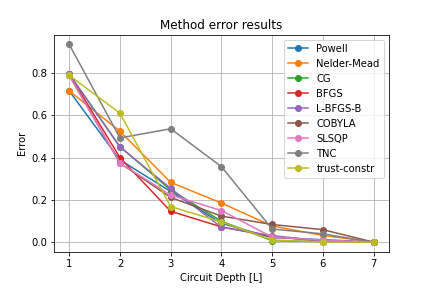

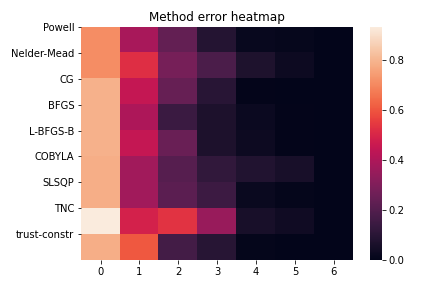

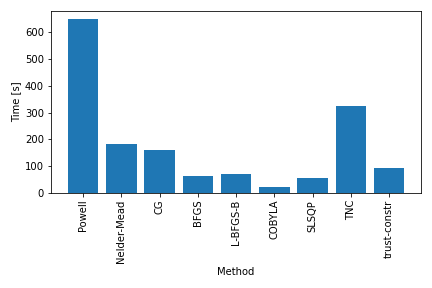

In [91]:
display(Image('Method error results.png'))
display(Image('Method error heatmap.png'))
display(Image('Method times for 7 layer circuit.png'))

# Result Discussion
In order to choose an optimization algorithm one of the most relevant parameters is time. So this rules methods like Powell and TNC from the start. Furthermore, given that we are studying an optimization problem, we can't really know which ones are correct. In other words, wheter the function got stuck in a local minima and did not find the global one. That is, we want to choose a fast method that is able to minimize the error the most for a relatively short ammount of layers. 

In this case the chosen method is the **BFGS**, which will be used in all further runs. It is important to note that running several times the different algorithms for the same random statevector can generate different results due to the complexity of the minimization function, but we can assume that this single run is sufficient enough in order to make this decision. In a practical sense, most methods chosen will lead to consisten results. 

## Task Solution
Because the vector we wish to find is random in nature a single run of the optimization would not be representative of the overall behavious we expect to find. So in the next cell we will be running the code for several different starting random statevector. 

In [93]:
#number of different random vectors
N = 8

#number of layers to test
Lmax = 7

#error results
#columns represent layers and rows different vectors
result = np.zeros((N,Lmax))

for i in range(N):
    #start run with a random vector
    random_sv = rand_state()

    #test for Lmax layers
    for L in range(1,Lmax):
        
        #starting random parameters
        theta_0 = 2*math.pi*np.random.random([4*2*L])
        
        #bounds and optimization
        opt.bounds = (0,2*math.pi)
        sol = opt.minimize(running_circuit,theta_0,args=(L,random_sv),method='BFGS')
        
        #storying results
        result[i,L-1] = sol.fun        


## Generating Figures

```
title = str(N) + ' random statevectors - Standard Circuit'
_ =plt.plot(range(1,Lmax+1),np.transpose(result),'-o')
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

title = str(N) + ' random statevectors Boxplot - Standard Circuit'
_ = plt.boxplot(result,patch_artist=True)
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

np.savetxt("8sv_Standard.csv",result, delimiter=",")


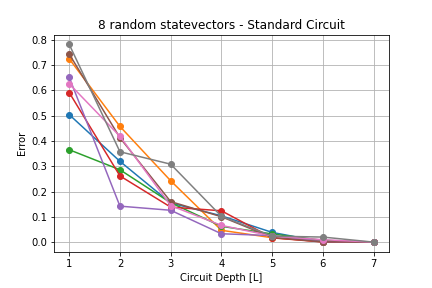

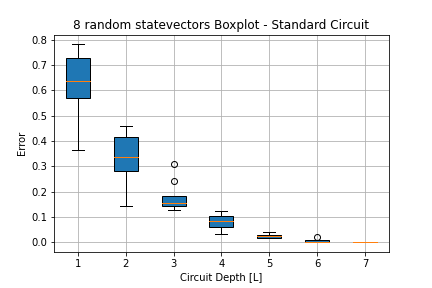

In [103]:
display(Image('8 random statevectors - Standard Circuit.png'))
display(Image('8 random statevectors Boxplot - Standard Circuit.png'))

## Result Discussion
From the images above it is clear to see that by the 5th layer, or when there are 40 degrees of freedom in the system, the circuit can replicate with accuracy the random vector. Also of note is the high variation that exists



# Different Circuits
The previous results are related to the optimization problem using only the $R_{x}$ and $R_{z}$ gates alongside CZ, but an interesting questions will be about how does the optimzation problem perform when trying out different combinations of parametrized gates.

This in order to judge whether the optimization is limited by the ammount of free parameters available or also the structure of the circuit. 

## CNOT
Hypothesis, the results will not change because neither the cz or cnot gate offer any degrees of freedom

### Defining Functions

In [104]:
#Defining the odd blocks 
def odd_block(qc,theta):
    for i in range(4):
        qc.rx(theta[i],i)  

        
        
#Defining the even blocks
def even_block(qc,theta):
    #rz gates
    for i in range(4):
        qc.rz(theta[i],i)
    #cz gates
    for i in range(4):
        for j in range(i+1,4):
            qc.cnot(i,j)            #This is the only change 

            
#Defining a layer
def circuit_layer(qc,theta1,theta2):
    odd_block(qc,theta1)
    even_block(qc,theta2)
    
#Check norm of the difference of two states
def check_diff(random_sv,circuit_sv):
    diff = circuit_sv - random_sv
    epsilon = np.linalg.norm(diff.data,ord=2)**2
    return epsilon 


#Creating the circuit and result 
#Theta is a 4*2L array 1D array of numbeers 
def running_circuit(theta,L,random_sv):
    
    #initiating circuit and vector 
    mycircuit = QuantumCircuit(4)
    initial_sv = Statevector.from_label('0000')
    
    #creating the layers
    for i in range(L):
        circuit_layer(mycircuit,theta[4*i:4*i+4],theta[4*i+4:4*i+8])
        
    #evolving the statevector
    circuit_sv = initial_sv.evolve(mycircuit)
    
    #comparing to the original 
    epsilon = check_diff(random_sv,circuit_sv)
    
    return epsilon

#### Example
Below is an example of the type of circuit we will be simulating. Note the CNOT gates instead of the CZ

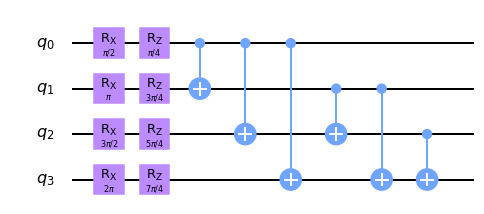

In [105]:
#Creation of a 4 qubit circuit
qc_example = QuantumCircuit(4)

#Input angles for our circuit 
theta_odd = [ math.pi/2, math.pi, 3*math.pi/2, 2*math.pi]
theta_even= [math.pi/4, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]

#Adding the layer
circuit_layer(qc_example,theta_odd,theta_even)

#Image of the resulting circuit 
qc_example.draw('mpl')

### Running the circuit

In [106]:
#number of different random vectors
N = 8

#number of layers to test
Lmax = 7

#error results
#Columns represent layers and rows different vectors
result = np.zeros((N,Lmax))

for i in range(N):
    #start run with a random vector
    random_sv = rand_state()

    #test for Lmax layers
    for L in range(1,Lmax):
        theta_0 = 2*math.pi*np.random.random([4*2*L])

        opt.bounds = (0,2*math.pi)
        sol = opt.minimize(running_circuit,theta_0,args=(L,random_sv),method='BFGS')
        result[i,L-1] = sol.fun       

### Generating Figures

```
title = str(N) + ' random statevectors - CNOT'
_ =plt.plot(range(1,Lmax+1),np.transpose(result),'-o')
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

title = str(N) + ' random statevectors Boxplot - CNOT'
_ = plt.boxplot(result,patch_artist=True)
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

np.savetxt("8sv_CNOT.csv",result, delimiter=",")


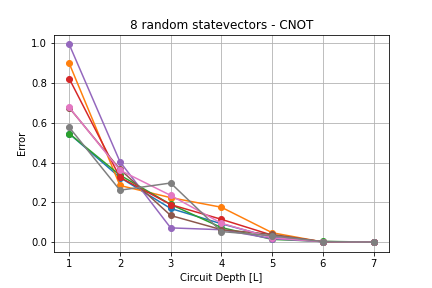

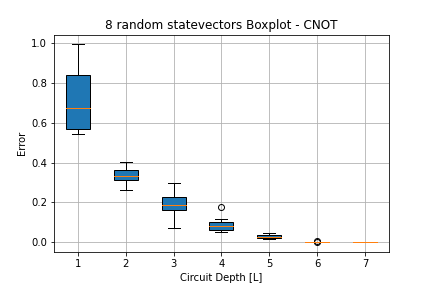

In [110]:
display(Image('8 random statevectors - CNOT.png'))
display(Image('8 random statevectors Boxplot - CNOT.png'))

### Result Discussion
Note the gray line where the error increasses on the third layer.
No significant difference from the standard circuit

## $R_{y}$ and $R_{z}$
The result will be very similar as well, not an important modification in the degrees of freedom 

### Defining Functions

In [112]:
#Defining the odd blocks 
def odd_block(qc,theta):
    for i in range(4):
        qc.ry(theta[i],i)  #This is the only change 
        
        
#Defining the even blocks
def even_block(qc,theta):
    #rz gates
    for i in range(4):
        qc.rz(theta[i],i)
    #cz gates
    for i in range(4):
        for j in range(i+1,4):
            qc.cz(i,j)            
            
#Defining a layer
def circuit_layer(qc,theta1,theta2):
    odd_block(qc,theta1)
    even_block(qc,theta2)
    
#Check norm of the difference of two states
def check_diff(random_sv,circuit_sv):
    diff = circuit_sv - random_sv
    epsilon = np.linalg.norm(diff.data,ord=2)**2
    return epsilon 


#Creating the circuit and result 
#Theta is a 4*2L array 1D array of numbeers 
def running_circuit(theta,L,random_sv):
    
    #initiating circuit and vector 
    mycircuit = QuantumCircuit(4)
    initial_sv = Statevector.from_label('0000')
    
    #creating the layers
    for i in range(L):
        circuit_layer(mycircuit,theta[4*i:4*i+4],theta[4*i+4:4*i+8])
        
    #evolving the statevector
    circuit_sv = initial_sv.evolve(mycircuit)
    
    #comparing to the original 
    epsilon = check_diff(random_sv,circuit_sv)
    
    return epsilon

#### Example

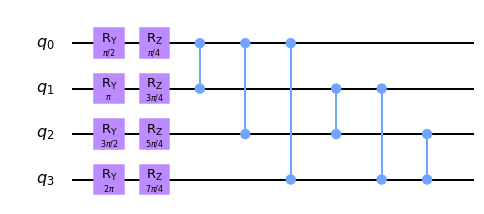

In [113]:
#Creation of a 4 qubit circuit
qc_example = QuantumCircuit(4)

#Input angles for our circuit 
theta_odd = [ math.pi/2, math.pi, 3*math.pi/2, 2*math.pi]
theta_even= [math.pi/4, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]

#Adding the layer
circuit_layer(qc_example,theta_odd,theta_even)

#Image of the resulting circuit 
qc_example.draw('mpl')

### Running the circuit

In [114]:
#number of different random vectors
N = 8

#number of layers to test
Lmax = 7

#error results
#Columns represent layers and rows different vectors
result = np.zeros((N,Lmax))

for i in range(N):
    #start run with a random vector
    random_sv = rand_state()

    #test for Lmax layers
    for L in range(1,Lmax):
        theta_0 = 2*math.pi*np.random.random([4*2*L])

        opt.bounds = (0,2*math.pi)
        sol = opt.minimize(running_circuit,theta_0,args=(L,random_sv),method='BFGS')
        result[i,L-1] = sol.fun       

### Generating Figures

```
title = str(N) + ' random statevectors - RyRz'
_ =plt.plot(range(1,Lmax+1),np.transpose(result),'-o')
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

title = str(N) + ' random statevectors Boxplot - RyRz'
_ = plt.boxplot(result,patch_artist=True)
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

np.savetxt("8sv_RyRz.csv",result, delimiter=",")


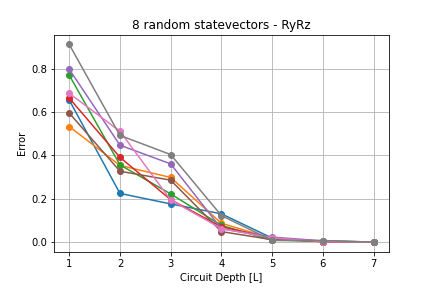

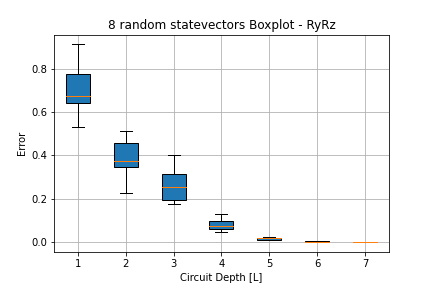

In [117]:
display(Image('8 random statevectors - RyRz.png'))
display(Image('8 random statevectors Boxplot - RyRz.png'))

### Result Discussion
What is going on


## U2 and Ry
Considering we are adding an extra degree of freedom to the system, I expect the number of layers to diminish. Now 12 degrees of freedom per layer. 
Since U2 includes a RZ rotation then we will also change the even layer gate to Ry

The U2 gate we're using can be parametrized as 
\begin{equation


**Insert definition of u2**

### Defining Functions

In [123]:
#Defining the odd blocks 
def odd_block(qc,theta):
    for i in range(4):
        qc.u2(theta[i],theta[i+4],i)  #First 4 numbers in theta are the phi rotations
                                      #Last 4 are the lambda rotations
        
        
#Defining the even blocks
def even_block(qc,theta):
    #rz gates
    for i in range(4):
        qc.ry(theta[i],i)
    #cz gates
    for i in range(4):
        for j in range(i+1,4):
            qc.cz(i,j)            
            
#Defining a layer
def circuit_layer(qc,theta1,theta2):
    odd_block(qc,theta1)
    even_block(qc,theta2)
    
#Check norm of the difference of two states
def check_diff(random_sv,circuit_sv):
    diff = circuit_sv - random_sv
    epsilon = np.linalg.norm(diff.data,ord=2)**2
    return epsilon 


#Creating the circuit and result 
#Theta is a 4*3L array 1D array of numbeers 
def running_circuit(theta,L,random_sv):
    
    #initiating circuit and vector 
    mycircuit = QuantumCircuit(4)
    initial_sv = Statevector.from_label('0000')
    
    #creating the layers
    for i in range(L):
        circuit_layer(mycircuit,theta[4*i:4*i+8],theta[4*i+4:4*i+12]) #adapt the limits for the parameters
        
    #evolving the statevector
    circuit_sv = initial_sv.evolve(mycircuit)
    
    #comparing to the original 
    epsilon = check_diff(random_sv,circuit_sv)
    
    return epsilon

#### Example

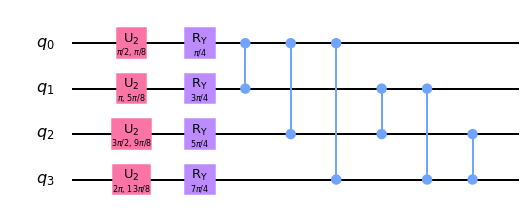

In [124]:
#Creation of a 4 qubit circuit
qc_example = QuantumCircuit(4)

#Input angles for our circuit 
theta_odd = [ math.pi/2, math.pi, 3*math.pi/2, 2*math.pi, math.pi/8, 5*math.pi/8, 9*math.pi/8, 13*math.pi/8]
theta_even= [math.pi/4, 3*math.pi/4, 5*math.pi/4, 7*math.pi/4]

#Adding the layer
circuit_layer(qc_example,theta_odd,theta_even)

#Image of the resulting circuit 
qc_example.draw('mpl')

In [125]:
#number of different random vectors
N = 8

#number of layers to test
Lmax = 7

#error results
#Columns represent layers and rows different vectors
result = np.zeros((N,Lmax))

for i in range(N):
    #start run with a random vector
    random_sv = rand_state()

    #test for Lmax layers
    for L in range(1,Lmax):
        theta_0 = 2*math.pi*np.random.random([4*3*L])

        opt.bounds = (0,2*math.pi)
        sol = opt.minimize(running_circuit,theta_0,args=(L,random_sv),method='BFGS')
        result[i,L-1] = sol.fun  

### Generating Figures

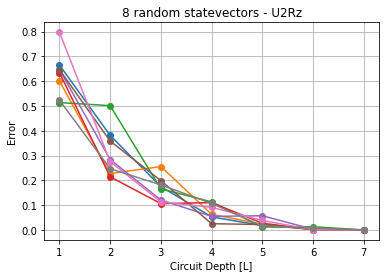

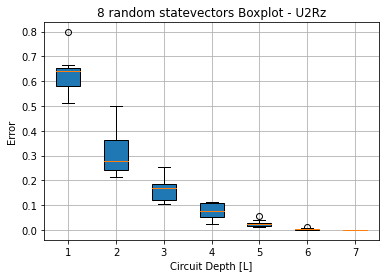

In [126]:
title = str(N) + ' random statevectors - U2Rz'
_ =plt.plot(range(1,Lmax+1),np.transpose(result),'-o')
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

title = str(N) + ' random statevectors Boxplot - U2Rz'
_ = plt.boxplot(result,patch_artist=True)
_ =plt.title(title)
_ =plt.xlabel('Circuit Depth [L]')
_ =plt.ylabel('Error')
_ =plt.grid(True)
_ =plt.savefig(title+'.png')
plt.show()

np.savetxt("8sv_U2Rz.csv",result, delimiter=",")


# Using a noisy circuit 
Adding gates adds noise so let's see what's up
